# Setting Up

In [7]:
import nltk.corpus

from config.constants import *
from config.utils import *

df = DATA_INPUTS['main_dataset']

if len(df) != 0:
    logger.info(f'Dataframe imported successfully with a length of {len(df)} 🎉')

2023-08-20 15:55:23.427 | INFO     | __main__:<module>:9 - Dataframe imported successfully with a length of 10000 🎉


In [8]:
print(f'There are {len(df.columns)} columns: {list(df.columns)}.')

There are 8 columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date', 'tokens', 'refined_text'].


In [9]:
categories = df.category.unique()
print(f'There are {len(categories)} columns:\n')

half = len(categories) // 2
left_col = categories[:half]
right_col = categories[half:]

for left, right in zip(left_col, right_col):
    print(f'{left: <25}{right}')

There are 12 columns:

ENTERTAINMENT            BUSINESS
COMEDY                   SCIENCE
QUEER VOICES             WORLD NEWS
TECH                     EDUCATION
WELLNESS                 MONEY
BLACK VOICES             ARTS & CULTURE


In [13]:
df.category.value_counts()

category
WELLNESS          2535
ENTERTAINMENT     2463
QUEER VOICES       959
BUSINESS           853
COMEDY             798
BLACK VOICES       686
WORLD NEWS         496
TECH               311
SCIENCE            310
MONEY              253
ARTS & CULTURE     190
EDUCATION          146
Name: count, dtype: int64

# Tokenizer

In [10]:
def tokenizer(text: str, stopwords: set = STOPWORDS, punctuations: set = PUNCTUATIONS) -> tuple[list, str]:
    emojis = demoji.findall(text)
    
    new_text = ''
    for character in text:
        if character in emojis.keys():
            new_text += str.join('_', str.split(emojis[character])) + ' '
        else:
            new_text += character
    
    lemmatizer = WordNetLemmatizer()
    lemmas = [ lemmatizer.lemmatize(word) for word in word_tokenize(new_text) ]
    tokens = [ str.lower(token) for token in lemmas if token not in stopwords and token not in punctuations ]
    
    refined_text = str.join(' ', tokens)
    
    if len(tokens) == 0:
        return ['NULL'], 'NULL'
    else:
        return tokens, refined_text

In [14]:
df['tokens'], df['refined_text'] = df.headline.apply(lambda x: tokenizer(x, STOPWORDS, PUNCTUATIONS)[0]), df.headline.apply(lambda y: tokenizer(y, STOPWORDS, PUNCTUATIONS)[-1])

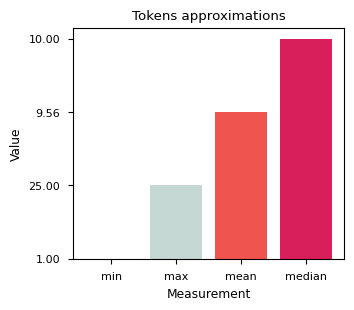

In [16]:
def token_approximation(text: str) -> int:
  return len(str.split(text))

ta = dict({
  'min': f'{np.min([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'max': f'{np.max([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'mean': f'{np.mean([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'median': f'{np.median([token_approximation(text) for text in df.refined_text.tolist()]):.2f}'
})

token_approximations = pd.DataFrame(list(ta.items()), columns=['measurement', 'value'])

plt.figure(figsize=(3.5, 3))
plt.style.use('seaborn-v0_8-paper')

plt.bar(token_approximations.measurement, token_approximations.value, color=['#fdf0d5', '#c6d8d3', '#f0544f', '#d81e5b'])
plt.title('Tokens approximations')
plt.xlabel('Measurement')
plt.ylabel('Value')
plt.show()

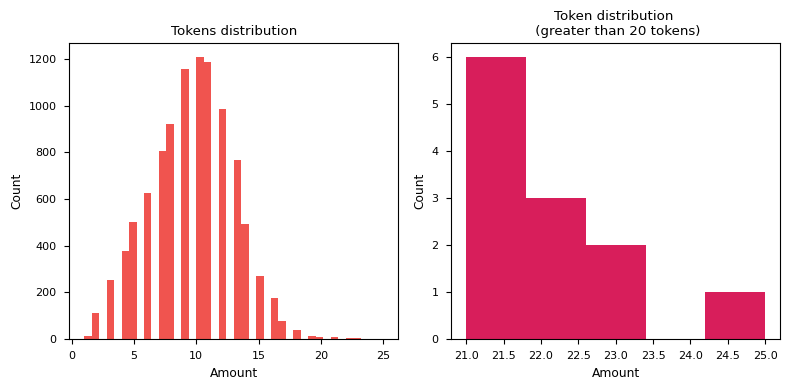

In [23]:
aux = df.copy(deep=True)
aux['tl'] = aux.tokens.apply(lambda x: len(x))
aux = aux.tl.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(aux, bins=40, color='#f0544f')
ax1.set_title('Tokens distribution')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Count')

aux2 = df.copy(deep=True)
aux2['tl'] = aux2.tokens.apply(lambda x: len(x))
aux2 = aux2.query('tl > 20')
aux2 = aux2.tl.tolist()

ax2.hist(aux2, bins=5, color='#d81e5b')
ax2.set_title('Token distribution \n (greater than 20 tokens)')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()


In [25]:
vocab = list()
for tokens in df.tokens:
    vocab.extend(tokens)

vocab = set(vocab)
vocab = dict(zip(vocab, range(2, len(vocab) + 2)))
vocab['UNK'] = 1
vocab['PAD'] = 0
vocab = dict(sorted(vocab.items(), key=lambda item: item[1]))

In [39]:
def get_ids(text: str, max_length: int) -> np.ndarray[int]:
  text = str.lower(text)
  vector = [vocab[word] if word in vocab.keys() else vocab['UNK'] for word in text.split()]
  vector = vector[:max_length] + [vocab['PAD']] * (max_length - len(vector))
  return np.array(vector)

def get_attention_mask(ids: np.ndarray[int]) -> np.ndarray[int]:
  return np.array([1 if id > 0 else 0 for id in ids])

def ids_decoder(ids: np.ndarray[int], vocab: dict[str, int]) -> str:
  reconstruction = list(vocab.keys())[list(vocab.values()).index(ids[0])]
  for i in ids[1:]:
      word = list(vocab.keys())[list(vocab.values()).index(i)]
      word = ' ' + word if word != 'PAD' else ''
      reconstruction += word
      
  return reconstruction

max_length = 32
sample_text = df.sample(1, random_state=26).refined_text.values[0]
input_ids = get_ids(sample_text, max_length)
attention_mask = get_attention_mask(input_ids)

input_ids, attention_mask

(array([10804,  4849, 12825,  2127,  6170,  9823,   616, 14837,  5054,
        11890,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [49]:
df['vector'] = df.refined_text.apply(lambda x: get_ids(text=x, max_length=32))

In [51]:
df

,link,headline,category,short_description,authors,date,tokens,refined_text,vector
13827,https://www.huffingtonpost.com/entry/benedict-...,Benedict Cumberbatch Does A Dramatic Reading O...,ENTERTAINMENT,The Sorcerer Supreme probably makes a mean tea.,Andy McDonald,2018-02-22,"[benedict, cumberbatch, does, a, dramatic, rea...",benedict cumberbatch does a dramatic reading o...,"[10013, 15569, 13633, 5931, 11716, 581, 5335, ..."
143195,https://www.huffingtonpost.com/entry/dogs-huma...,The Best Dogs-With-Human-Hands Music Video You...,COMEDY,This music video by Brussels-based band Record...,,2014-01-05,"[the, best, dogs-with-human-hands, music, vide...",the best dogs-with-human-hands music video you...,"[14326, 9360, 13754, 1076, 3946, 318, 4423, 10..."
110389,https://www.huffingtonpost.comhttp://www.celeb...,Johnny Depp And Amber Heard Lock Lips On The R...,ENTERTAINMENT,,,2015-01-11,"[johnny, depp, and, amber, heard, lock, lips, ...",johnny depp and amber heard lock lips on the r...,"[513, 11647, 10490, 11056, 13398, 7983, 15329,..."
160567,https://www.huffingtonpost.com/entry/new-fun-a...,New Fun. Album Coming Next Year? Band Would 'L...,ENTERTAINMENT,Still basking in the Grammy-winning success of...,,2013-07-05,"[new, fun, album, coming, next, year, band, wo...",new fun album coming next year band would 'lik...,"[13013, 9455, 1219, 715, 3660, 10823, 9299, 12..."
86955,https://www.huffingtonpost.com/entry/rihanna-c...,Rihanna Talks Getting Back Together With Chris...,ENTERTAINMENT,"""I finally had to say, ‘Uh-oh, I was stupid th...",Lily Karlin,2015-10-06,"[rihanna, talks, getting, back, together, with...",rihanna talks getting back together with chris...,"[14775, 8504, 3394, 9282, 8221, 10116, 4963, 4..."
...,...,...,...,...,...,...,...,...,...
207389,https://www.huffingtonpost.com/entry/the-simps...,'The Simpsons' 500th Episode Message To Viewer...,COMEDY,"""The Simpsons"" aired its 500th episode on Sund...",,2012-02-20,"['the, simpsons, 500th, episode, message, to, ...",'the simpsons 500th episode message to viewers...,"[13891, 14276, 13913, 1633, 3301, 3591, 8650, ..."
84360,https://www.huffingtonpost.com/entry/guy-cryin...,Nothing You've Seen Compares To This Dude Cryi...,COMEDY,Get over it. Or not.,Ron Dicker,2015-11-03,"[nothing, you, 've, seen, compares, to, this, ...",nothing you 've seen compares to this dude cry...,"[13660, 318, 964, 14025, 12095, 3591, 3021, 11..."
86011,https://www.huffingtonpost.com/entry/google-bo...,Google's Massive Book-Scanning Project Is Lega...,TECH,The Authors Guild had claimed that the effort ...,"Joseph Ax, Reuters",2015-10-16,"[google, 's, massive, book-scanning, project, ...",google 's massive book-scanning project is leg...,"[2947, 5052, 11186, 5117, 6569, 6143, 9280, 13..."
181737,https://www.huffingtonpost.com/entry/gps-guide...,GPS Guide: Christine Hassler's Thanksgiving Gr...,WELLNESS,The stress and strains of our always-connected...,,2012-11-22,"[gps, guide, christine, hassler, 's, thanksgiv...",gps guide christine hassler 's thanksgiving gr...,"[7475, 9078, 9185, 39, 5052, 3911, 12367, 9078..."
